### Importing Libraries

In [ ]:
# !pip install torchprofile 1>/dev/null

In [4]:
import torch
import torch.nn as nn
import math
import copy
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List
import torch.nn.init as init
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

#from torchprofile import profile_macs # Helps us to obtain mac calculations


assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

### DynamicConnectionLayer


$h_j$ and $h_i$ are hidden states of the controller at anchor points which should be size of 35. We should consider $j<i$,
$W_{prev}$, $W_{curr}$ and $v$ are trainable parameters. The choice of whether we concatenate the previous layers output or not determine the ground truth of sigmoid for training.


$$P\left(Layer\ j\ is\ an\ input\ to\ Layer\ i\right) = \sigma\left(v^T \tanh\left(W_{prev} \star h_j + W_{curr} \star h_i\right)\right)$$

In [5]:
class DynamicConnectionLayer(nn.Module):

    """
       This class is used to define anchor points in the controller network.

    """
    def __init__(self, num_input, hidden_size,intr_size=30):
        """
        Args:
            num_input (int): Number of input connections.
            hidden_size (int): Size of the hidden layer.
            intr_size (int, optional): Intermediate size. Defaults to 30.
        """
        super(DynamicConnectionLayer, self).__init__()
        self.num_input = num_input
        self.hidden_size = hidden_size
        self.intr_size=intr_size #intermeditate size
        layers_array = []

        for i in range(num_input):
            # print(input_size)
            layers_array.append(nn.Linear(hidden_size,intr_size, bias = False))  #W_prev parameter
            layers_array.append(nn.Linear(hidden_size,intr_size, bias = False))   #W_curr parameter
            layers_array.append(nn.Linear(intr_size,1, bias = False))  #v
        self.layers = nn.ModuleList(layers_array)

    def forward(self, prev_hidden_states, current_hidden_state):
        """
        Args:
            prev_hidden_states: previous states anchor points
            current_hidden_state: current state anchor point

        Returns:
            probabilities: connection probability of previous layer is an input to current layer

        """

        probabilities=[]
        for i in range(self.num_input):
            prev_term = self.layers[3*i](prev_hidden_states[i])  # prev_term

            curr_term = self.layers[3*i + 1](current_hidden_state)  # curr_term

            connection_input = torch.tanh(prev_term + curr_term)
            connection_probability = torch.sigmoid(self.layers[3*i + 2](connection_input))  # Apply sigmoid activation to get probabilities

            probabilities.append(connection_probability)

        return probabilities



### Controller network

Controller is a two - layer LSTM with 35 hidden units on each layer.

It predicts filter height - $[1,3,5,7]$, filter width - $[1,3,5,7]$ ,number of filters - $[24, 36, 48, 64]$ , stride is (1,1) for each layer.

Every prediction is carried out by a softmax classifier and then fed into the next time step as input.

The controller uses skip connections as anchor points to decide what layers it wants as inputs to the current layer. here, every prediction is carried out by sigmoid classifier and then fed into the next time step as input.

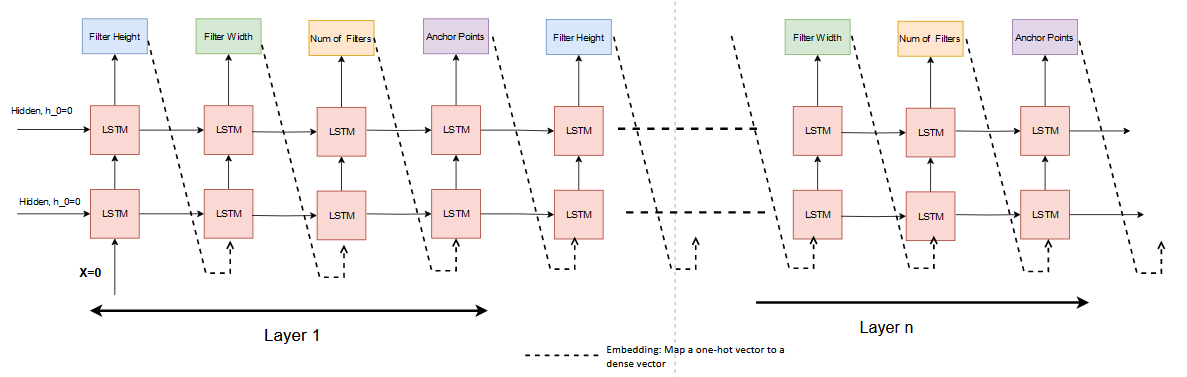


In [6]:
class Controller(nn.Module):
    def __init__(self, conv_layers_num, input_size, hidden_size, lstm_num_layers, layers_num, layers_sizes):
        """ Definition of the controller module
        ---------
        conv_layers_num is the total num of conv layers generating for the child architecture
        input_size: the input size to the LSTM
        hidden_size: the number of hidden units of the LSTM
        lstm_num_layers: the number of layers in the lstm
        layers_num :  the total number parameters used to define conv layer for prediction.
        """
        super(Controller, self).__init__()
        self.conv_layers_num =conv_layers_num
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.layers_num = layers_num
        self.layers_sizes = layers_sizes

        # Define LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_num_layers, batch_first=True)

        # Define dynamic connection layers
        self.dynamic_layers = nn.ModuleList([DynamicConnectionLayer(_+1, hidden_size) for _ in range(conv_layers_num-1)])
        # Create an linear layer

        self.Embedding_softmax = nn.ModuleList([nn.Linear(size, input_size, bias=False) for size in layers_sizes])

        self.Embedding_attn = nn.ModuleList([nn.Linear(hidden_size,input_size, bias=False)])
        self.Embedding_attn.extend( [nn.Linear(size+1,input_size, bias=False) for size in range(conv_layers_num-2)])

        # Define linear layers for predictions
        self.prediction_layers = nn.ModuleList([nn.Linear(hidden_size, size) for size in layers_sizes])

    def forward(self, inference=True,child_network_labels=None,child_network_skips=None):
        """
        The code can operate in two modes: inference and training.

        Inference Mode (Prediction):
          In this mode, the code uses a pre-trained model to make predictions based on the input.
          It doesn't involve any learning or updates to the system.

        Training Mode:
          In this mode, the code uses the input and potentially some
          additional information (child_network_labels, child_network_skips) to train the model.
          It refines the system based on the input and desired outcome.
        Args:
            child_network_labels : randomly generated labels as list of size(conv_layer_nums/len(vocab))
            child_network_skips: randomly generated skip labels as a dict type of size(conv_layer_num)

        Returns:
            targets : Predicted probabilities of child_labels (output->list of Tensors)
            skip_targets:Predicted probabilities of skip_labels (output -> dict consists of tensors)

        """

        targets = []
        anchor_points=[]
        skip_targets={}
        skip_input_index=0
        threshold=torch.Tensor([0.5])
        hidden, cell = torch.zeros(self.lstm_num_layers, self.hidden_size), torch.zeros(self.lstm_num_layers,self.hidden_size)
        if inference:
          num_forwards = 1
        else:
          num_forwards = len(child_network_labels)
        input = torch.zeros(num_forwards,self.input_size)
        input_test=torch.zeros(num_forwards,self.input_size)


        for curr_conv_layer in range(self.conv_layers_num):
                for i in range(self.layers_num+1):
                    if i < self.layers_num:
                        input, (hidden, cell) = self.lstm(input, (hidden, cell))
                        # Flatten the input for linear layer
                        input = self.prediction_layers[i](input.view(input.size(0),-1))
                        targets.append(input)
                        if inference:
                            input = torch.nn.functional.one_hot(torch.argmax(input, dim=1).unsqueeze(1),num_classes=input.size(dim=1)).float()
                        else:
                            input_index = curr_conv_layer*self.layers_num+i
                            childs_labels=[]
                            for child_label in child_network_labels:
                              childs_labels.append(child_network_labels[child_label][input_index])
                            input = torch.nn.functional.one_hot(torch.tensor([childs_labels]),num_classes=input.size(dim=1)).float()
                        input=self.Embedding_softmax[i](input).view(input_test.size())
                    else:
                    # Apply dynamic connections
                      anchor_current,(hidden,cell)=self.lstm(input, (hidden, cell))
                      if len(anchor_points)>0:
                          input=self.dynamic_layers[curr_conv_layer-1](anchor_points,anchor_current)
                          skip_targets[curr_conv_layer-1]=input
                          if inference:
                            input = (torch.tensor(input)>threshold).float()
                          else:
                            childs_skips=[]
                            for child_skips in child_network_skips:
                              childs_skips.append(child_network_skips[child_skips][skip_input_index])
                            input =(torch.tensor([childs_skips])).float()
                            skip_input_index =skip_input_index+1
                          if(curr_conv_layer!=self.conv_layers_num-1):
                            input = self.Embedding_attn[curr_conv_layer](input.float()).view(input_test.size())
                      else:
                          input=self.Embedding_attn[curr_conv_layer](anchor_current)
                      anchor_points.append(anchor_current)

        return targets,skip_targets


In [7]:
class Controller_Full(nn.Module):
    def __init__(self, conv_layers_num, input_size, hidden_size, lstm_num_layers, layers_num, layers_sizes):
        """ Definition of the controller module
        ---------
        conv_layers_num is the total num of conv layers generating for the child architecture
        input_size: the input size to the LSTM
        hidden_size: the number of hidden units of the LSTM
        lstm_num_layers: the number of layers in the lstm
        layers_num :  the total number parameters used to define conv layer for prediction.
        """
        super(Controller, self).__init__()
        self.conv_layers_num =conv_layers_num
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.layers_num = layers_num
        self.layers_sizes = layers_sizes
        self.conv_layers_total=conv_layers_num

        # Define LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_num_layers, batch_first=True)

        # Define dynamic connection layers
        self.dynamic_layers = nn.ModuleList([DynamicConnectionLayer(_+1, hidden_size) for _ in range(conv_layers_num-1)])
        # Create an linear layer

        self.Embedding_softmax = nn.ModuleList([nn.Linear(size, input_size, bias=False) for size in layers_sizes])

        self.Embedding_attn = nn.ModuleList([nn.Linear(hidden_size,input_size, bias=False)])
        self.Embedding_attn.extend( [nn.Linear(size+1,input_size, bias=False) for size in range(conv_layers_num-2)])

        # Define linear layers for predictions
        self.prediction_layers = nn.ModuleList([nn.Linear(hidden_size, size) for size in layers_sizes])
    def extend_network(self, conv_layers_num):
      self.conv_layers_num=conv_layers_num
      if(self.conv_layers_total>conv_layers_num):
         self.__init__(conv_layers_num, self.input_size,self.hidden_size,self.lstm_num_layers,self.layers_num, self.layers_sizes)

    def forward(self, inference=True,child_network_labels=None,child_network_skips=None):
        """
        The code can operate in two modes: inference and training.

        Inference Mode (Prediction):
          In this mode, the code uses a pre-trained model to make predictions based on the input.
          It doesn't involve any learning or updates to the system.

        Training Mode:
          In this mode, the code uses the input and potentially some
          additional information (child_network_labels, child_network_skips) to train the model.
          It refines the system based on the input and desired outcome.
        Args:
            child_network_labels : randomly generated labels as list of size(conv_layer_nums/len(vocab))
            child_network_skips: randomly generated skip labels as a dict type of size(conv_layer_num)

        Returns:
            targets : Predicted probabilities of child_labels (output->list of Tensors)
            skip_targets:Predicted probabilities of skip_labels (output -> dict consists of tensors)

        """

        targets = []
        anchor_points=[]
        skip_targets={}
        skip_input_index=0
        threshold=torch.Tensor([0.5])
        hidden, cell = torch.zeros(self.lstm_num_layers, self.hidden_size), torch.zeros(self.lstm_num_layers,self.hidden_size)
        if inference:
          num_forwards = 1
        else:
          num_forwards = len(child_network_labels)
        input = torch.zeros(num_forwards,self.input_size)
        input_test=torch.zeros(num_forwards,self.input_size)


        for curr_conv_layer in range(self.conv_layers_num):
                for i in range(self.layers_num+1):
                    if i < self.layers_num:
                        input, (hidden, cell) = self.lstm(input, (hidden, cell))
                        # Flatten the input for linear layer
                        input = self.prediction_layers[i](input.view(input.size(0),-1))
                        targets.append(input)
                        if inference:
                            input = torch.nn.functional.one_hot(torch.argmax(input, dim=1).unsqueeze(1),num_classes=input.size(dim=1)).float()
                        else:
                            input_index = curr_conv_layer*self.layers_num+i
                            childs_labels=[]
                            for child_label in child_network_labels:
                              childs_labels.append(child_network_labels[child_label][input_index])
                            input = torch.nn.functional.one_hot(torch.tensor([childs_labels]),num_classes=input.size(dim=1)).float()
                        input=self.Embedding_softmax[i](input).view(input_test.size())
                    else:
                    # Apply dynamic connections
                      anchor_current,(hidden,cell)=self.lstm(input, (hidden, cell))
                      if len(anchor_points)>0:
                          input=self.dynamic_layers[curr_conv_layer-1](anchor_points,anchor_current)
                          skip_targets[curr_conv_layer-1]=input
                          if inference:
                            input = (torch.tensor(input)>threshold).float()
                          else:
                            childs_skips=[]
                            for child_skips in child_network_skips:
                              childs_skips.append(child_network_skips[child_skips][skip_input_index])
                            input =(torch.tensor([childs_skips])).float()
                            skip_input_index =skip_input_index+1
                          if(curr_conv_layer!=self.conv_layers_num-1):
                            input = self.Embedding_attn[curr_conv_layer](input.float()).view(input_test.size())
                      else:
                          input=self.Embedding_attn[curr_conv_layer](anchor_current)
                      anchor_points.append(anchor_current)

        return targets,skip_targets
    
             


##Child Network Class considering Child_labels and Child_skips


Child network generate a sample architectures from randomly generated child_labels and child_skips.


Sample Architectures will be in the form of:
Conv2d ----> BatchNorm2d ----> ReLU

Let's see example of 3 conv layers below sample child_model.
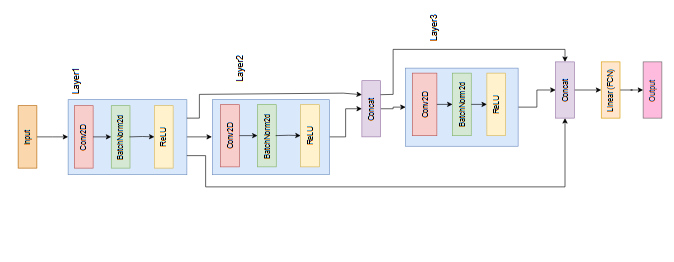


In [19]:
class child_network(nn.Module):
  def __init__(self, input_size, output_classes, conv_vocab, child_network_labels, child_network_skips):
     """ Definition of the child network module
        ---------
        input_size: The input shape of the dataset we are evaluating our child network on
        output_classes: The output classes number
        conv_vocab: Contains information regarding the convolutional layer information such as # kernel size and # filters
        child_network_labels: The labels corresponding to the conv layers of the child network
        child_network_skips: The dictionary representation of the skip connection information
        ---------
        Dependent Parameters Drawn from the given information
        ---------
        layers_num : The total number of convolutional layers
        """
     super(child_network,self).__init__()
     layers_array=[]
     conv_layers = len(child_network_skips)+1
     layer_param_num = int(len(child_network_labels)/conv_layers)

     conv_layer_dimensions = {}

     


     for conv_layer_num in range(conv_layers):

        layers_array.append(nn.Conv2d(input_size[1], vocab[2][child_network_labels[conv_layer_num * layer_param_num + 2]],
                                          kernel_size=tuple([vocab[0][child_network_labels[conv_layer_num * layer_param_num]],
                                                             vocab[1][child_network_labels[conv_layer_num * layer_param_num + 1]]]),
                                          stride=(1, 1)))
        
        

        layers_array.append(nn.BatchNorm2d(vocab[2][child_network_labels[conv_layer_num * layer_param_num + 2]]))
        layers_array.append(nn.ReLU())
        
        # Update height
        input_size[2] = math.floor((input_size[2] - vocab[0][child_network_labels[conv_layer_num * layer_param_num]])) + 1
        # Update width
        input_size[3] = math.floor((input_size[3] - vocab[0][child_network_labels[conv_layer_num * layer_param_num + 1]])) + 1

        # Update number of channels
        if(conv_layer_num>0):
          conv_check=0
          input_size[1]= vocab[2][child_network_labels[conv_layer_num * layer_param_num + 2]]
          for concat_info in child_network_skips[conv_layer_num-1]:
            if(concat_info):
              input_size[1] +=conv_layer_dimensions[conv_check][0]
              input_size[2] = max(input_size[2],conv_layer_dimensions[conv_check][1])
              input_size[3] = max(input_size[3],conv_layer_dimensions[conv_check][2])
            conv_check+=1
          layers_array.append(nn.Dropout(p=0.2, inplace=False))
        else:
          input_size[1]= vocab[2][child_network_labels[conv_layer_num * layer_param_num + 2]]
        conv_layer_dimensions[conv_layer_num]=[input_size[1],input_size[2],input_size[3]]
        # layers_array.append(nn.Dropout(p=0.2))
        # layers_array.append(nn.Dropout(p=0.5, inplace=False))
    

    #  layers_array.append(nn.Dropout(0.5))
     layers_array.append(nn.Linear(input_size[1] * input_size[2] * input_size[3], output_classes))
     self.layers = nn.ModuleList(layers_array)
     print(self.layers)
     self.child_network_skips = child_network_skips
     self.conv_layer_dimensions=conv_layer_dimensions
  def forward(self, input):
        '''
          if:
             layer 1 it forward pass through conv --> BatchNorm ---> Relu
         else :
          rest of layers it it perform forward pass through conv --> BatchNorm ---> Relu
                after check for any skip conection if exist concat connection with padding
         for every layer output is stored in 'outputs' dictionary

        '''

        outputs = {}
        for conv_layer_num in range(len(self.child_network_skips) + 1):
            # Initial layer without skip connections
            if conv_layer_num == 0:
                # Forward pass through the current convolutional layer with batchnorm and ReLU
                for layer in self.layers[conv_layer_num * 3: conv_layer_num * 3 + 2]:
                    input = layer(input)

            else:
                # Forward pass through the current convolutional layer with batchnorm and ReLU
                for layer in self.layers[(conv_layer_num -1)* 4+3: (conv_layer_num -1)* 4+ 6]:
                    input = layer(input)
                # Concatenate skip connections with padding if necessary
                conv_check=0
                for concat_info in self.child_network_skips[conv_layer_num-1]:
                  if(concat_info):
                    out1=outputs[conv_check]
                    out2=input

                    padding = [abs((out2.size(dim) - out1.size(dim))) // 2 for dim in (2, 3)]
                    padding_error=[abs((out2.size(dim) - out1.size(dim))) % 2 for dim in (2, 3)]


                    if(out1.size(2)>out2.size(2)):
                        if out1.size(3)>out2.size(3):
                          out_padded1=out1
                          out_padded2 = F.pad(F.pad(out2, (padding[1], padding[1], padding[0], padding[0])),(0,padding_error[1],0,padding_error[0]))
                        else:
                          out_padded1=F.pad(F.pad(out1, (padding[1], padding[1], 0, 0)),(0,padding_error[1],0,0))
                          out_padded2=F.pad(F.pad(out2, (0,0, padding[0], padding[0])),(0,0,0,padding_error[0]))


                    else:
                        if(out1.size(3)>out2.size(3)):
                          out_padded1=F.pad(F.pad(out1, (0,0, padding[0], padding[0])),(0,0,0,padding_error[0]))
                          out_padded2=F.pad(F.pad(out2, (padding[1], padding[1], 0,0)),(0,padding_error[1],0,0))
                        else:
                          out_padded1 = F.pad(F.pad(out1, (padding[1], padding[1], padding[0], padding[0])),(padding_error[1],0,padding_error[0],0))
                          out_padded2=out2
                    input = torch.cat([out_padded1, out_padded2], dim=1)  # Concatenate the padded out1 with out2

                  conv_check+=1

            # Save the output for skip connections
            outputs[conv_layer_num] = input.clone()


        # Flatten and apply softmax to the final linear layer
        input = input.view(-1, input.size(1) * input.size(2) * input.size(3))
        input = self.layers[-1](input)


        return input

## Input values

**num_childs:** Number of child nodes (possibly in a search space).

**conv_layers_num:** Number of convolutional layers.

**input_size:** Dimensionality of the input data to controller

**hidden_size:** Dimensionality of the hidden state in the LSTM unit.

**lstm_num_layers:** Number of LSTM layers stacked on top of each other.

**FC_layers_num:** Number of fully-connected layers after the LSTM.

**FC_layers_sizes:** A list specifying the number of units in each fully-connected layer.

**Controller_Check:** it create instance of Controller Class

In [12]:
# Example usage:
num_childs= 5000 # amount of architectures to be generated 
conv_layers_num =5
input_size = 1
hidden_size = 35
lstm_num_layers = 1
FC_layers_num = 3
FC_layers_sizes = [4, 4, 4]
controller_check = Controller(conv_layers_num, input_size, hidden_size, lstm_num_layers, FC_layers_num, FC_layers_sizes)
targets, skip_targets=controller_check()

In [13]:
"""
Vocabulary:
  vocab[0] and vocab[1] represent kernel sizes, both having values [1, 3, 5, 7].
   vocab[2] represents convolutional layer choices, having values [24, 36,48, 64].
Output Classes:
  output_classes is set to 10, which is the number of classes in the final output.
Input Shape
  input is a random tensor with shape (1, 3, 32, 32). This is consistent with the typical shape of an input image with three color channels
"""
vocab={}
vocab[0]=[1, 3, 5, 7]  #kernel height
vocab[1]=[1, 3, 5, 7]     #kernel width
vocab[2] = [24, 36, 48, 64]     #num of filters [24, 36, 48, 64]  
output_classes = 10
input = torch.randn(1,3,28,28)

# vocab[2][[3,2,3,3,2,1,0,2,3,1,3,3,2,1,3][0 * 5]]

## generate random child_ labels

Randomly generate child_labels for each child.
For Example,

**Outer loop:** iterates num_child times.
Let's assume num_childs is 2 (two child nodes).


**Inner loop:** iterates num_layers times.Imagine num_layers is 5 (five conv layers for each child).

**Innermost loop:**iterates size_predicts times.Let's say size_predict is 3 (three predictions[filter heigth,width,num of filters] per layer). Inside this loop, generates a random index within the vocabulary for a specific prediction.
   
   output (dict) : len(num_childs) and each key is of len(num_layers*size_predicts) ex:3x5=15

   sample example:
   
   {0: array([2, 1, 1, 1, 1, 0, 0, 3, 1, 2, 2, 1, 0, 0, 0]), 1: array([3, 0, 3, 1, 3, 2, 0, 3, 1, 3, 1, 0, 1, 3, 3])}



In [14]:
class child_network_generate_random:
    """
     this class randomly generates the child labels
      Args:
          num_childs: number of childs
          num_layers: number of conv layers
          size_predict: number of layer parameter (kernel height,width, no of channels)
          vocab: represents kernel sizes, conv layer choices
      result:
          randomly generated labels for each conv layer

    """
    def __init__(self, num_childs, num_layers, size_predict, vocab):
        self.labels = {}
        for num_child in range(num_childs):
            labels_num_child = []
            for num_layer in range(num_layers):
                labels_num_layer = []
                for predict in range(size_predict):
                    labels_num_layer.append(random.randrange(len(vocab[predict])))
                labels_num_child.append(labels_num_layer)
            self.labels[num_child] = np.concatenate(np.array(labels_num_child))

## child_network_skip_generate_random:

Randomly generates skip connection for each layer.

**Outer loop:** iterates num_child times.
Let's assume num_childs is 2 (two child nodes).

**Inner loop:** Intial layer has no skip connection.It iterates num_layers-1 times.Imagine num_layers is 5 (five conv layers for each child).

For every layer, it randomly generates 0(no skip connection) or 1(skip connection) wrt to previous layer

**Ex:** for 3rd layer it checks with 1,2 and
  5th layer it checks with 1,2,3,4 layers generate a list.

  Sample example:
  
   {0: {0: [1], 1: [0, 0], 2: [0, 0, 0], 3: [1, 0, 1, 1]}, 1: {0: [0], 1: [1, 0], 2: [0, 1, 0], 3: [0, 1, 0, 1]}}


In [15]:
class child_network_generate_skip_random:
  """
  Args:
     num_layers: number of conv layers
  output:
      skips: stores dictionary type of n-1 conv layer.
             Each layer checks  with previous layers

  """
  def __init__(self,num_layers,num_childs =1 ):
      self.skips={}
      for num_child in range(num_childs):
        skip_child={}
        for num_layer in range(num_layers-1):
          labels_num_layer = []
          for predict in range(num_layer+1):
                    labels_num_layer.append(random.randrange(2))
          skip_child[num_layer]=labels_num_layer
        self.skips[num_child] = skip_child

In [16]:

child_skips = child_network_generate_skip_random(conv_layers_num,num_childs).skips
child_labels = child_network_generate_random(num_childs, conv_layers_num, len(vocab), vocab).labels

In [ ]:
from torch.utils.data import Dataset, DataLoader



# **** #  Create a dataset of the skips and label in preparation for training the controller #******#




class CustomDataset(Dataset):
    def __init__(self, skips_values, label_values, reward_values):
        self.skips_values = skips_values
        self.label_values = label_values
        self.reward_values = reward_values
        # self.children = list(skips_values.keys())  # Assuming all dictionaries have the same keys

    def __len__(self):
        return len(self.reward_values)  # Assuming rewards define the number of samples

    def __getitem__(self, idx):
        # For each child, fetch the corresponding skip and label by index
        # This example assumes the length of skips and labels matches the length of rewards for simplicity
        skips = self.skips_values[idx]
        labels = self.label_values[idx]
        rewards = self.reward_values[idx]
        return skips, labels, rewards

  

def custom_collate_fn(batch):
    # 'batch' is a list of tuples returned by CustomDataset.__getitem__
    skips_batch, labels_batch, rewards_batch = [], [], []
    for skips, labels, rewards in batch:
        skips_batch.append(skips)
        labels_batch.append(labels)
        rewards_batch.append(rewards)
    # Return a dictionary of batches
    
    return  dict(skips_batch), dict(labels_batch), rewards_batch #{"skips": skips_batch, "labels": labels_batch, "rewards": rewards_batch}

dataset = CustomDataset(child_skips_values, child_labels_values, rewards_values)

# Create the DataLoader with the custom collate function
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)

Preview random child models

In [ ]:
# visualisation
#%pip install torchview
import torchvision
from torchview import draw_graph

In [ ]:
controller_archi=Controller(conv_layers_num, input_size, hidden_size, lstm_num_layers, FC_layers_num, FC_layers_sizes)
architecture = 'controller_archi'
# model_graph = draw_graph(controller_archi,graph_dir ='TB' ,input_size=[input_size], roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph


In [ ]:
model=child_network([1,3,28,28],7,vocab,[2, 1, 1, 1, 1, 3, 2, 2, 0, 1, 0, 3, 3, 2, 1],{0: [0], 1: [1, 1], 2: [0, 1, 0], 3: [1, 0, 1, 0]})
architecture = 'child_model'
model_graph = draw_graph(model, input_size=(1,3,28,28),graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

**CIFAR-10 dataset**

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Assuming you have a CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training set into Trainset45000 and Validationset5000
train_size = 45000
val_size = 5000
train_dataset, val_dataset = random_split(cifar10_train_dataset, [train_size, val_size])

# Define data loaders
batch_size = 32
num_epochs=20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
cifar_batch = next(iter(train_loader)) 

print(cifar_batch[1].shape)

**Dertaminist dataset**


In [17]:
from medmnist import DermaMNIST

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = DermaMNIST(split="train", transform= data_transform, download=True)
valida_dataset = DermaMNIST(split="val", transform=data_transform, download=True)


n_classes = 7
num_epochs = 20

# print(type(train_dataset))

# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
Mtrain_loader = DataLoader(dataset=train_dataset, batch_size= 32, shuffle=True)
Mtrain_loader_at_eval = DataLoader(dataset=valida_dataset, batch_size= 32, shuffle=False)
# Mtest_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

batch = next(iter(Mtrain_loader))
input = batch[0].float()
print(input)
print("===================")
# print(test_dataset)


Using downloaded and verified file: /home/ifedayo/.medmnist/dermamnist.npz
Using downloaded and verified file: /home/ifedayo/.medmnist/dermamnist.npz
tensor([[[[ 0.8980,  0.8980,  0.8980,  ...,  0.9765,  0.9608,  0.9529],
          [ 0.8824,  0.8824,  0.8980,  ...,  0.9451,  0.9294,  0.9216],
          [ 0.8667,  0.8745,  0.8980,  ...,  0.9294,  0.9137,  0.9137],
          ...,
          [ 0.8824,  0.8902,  0.9137,  ...,  0.8196,  0.8196,  0.8196],
          [ 0.8588,  0.8824,  0.8980,  ...,  0.8118,  0.8118,  0.8118],
          [ 0.8510,  0.8667,  0.8745,  ...,  0.7961,  0.8039,  0.8039]],

         [[ 0.2941,  0.2941,  0.2941,  ...,  0.4196,  0.4275,  0.4353],
          [ 0.2784,  0.2784,  0.2941,  ...,  0.3882,  0.3961,  0.4039],
          [ 0.2627,  0.2706,  0.2941,  ...,  0.3804,  0.3804,  0.3804],
          ...,
          [ 0.3412,  0.3569,  0.3804,  ...,  0.3255,  0.3255,  0.3255],
          [ 0.3255,  0.3490,  0.3647,  ...,  0.2941,  0.2941,  0.3020],
          [ 0.3176,  0.333

## Generating child_models and training each Child model with CIFAR-10 dataset

Generate n number of child models where,
each Child Model is trained with the **ADAM optimizer**  with a learning rate of **0.1**.

The **reward** used for updating the controller is the maximum validation accuracy of the last 5 epochs cubed.

In [62]:
import os
import pandas as pd
import gc

def To_saveR(id, skips, labels, rewards):     # convert to a saveable format for unique architecture
  data=[]
  data.append({"id": id, "label": labels, "skips": skips, "rewards": rewards})
  df = pd.DataFrame(data)
  return df

def Train_random_models(R_labels, R_skips, num_epochs, learning_rate = 0.1):
    child_model = child_network([1,3,28,28],7,vocab,R_labels, R_skips)
    # model_parameters = child_model.parameters()
    # print(model_parameters)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    child_model = child_model.to(device)
    
    
    summary(child_model,(3,28,28), device= "cuda")
    optimizer = Adam(child_model.parameters(), lr=learning_rate)
    validation_accuracies = []
    reward_per_20 = []
    # start_time = time.time()
    id = 0
    for epoch in range(200):
        child_model.train()
        for inputs, targets in Mtrain_loader:
            inputs = inputs.float().to(device)
            # F.dropout(inputs, p=0.2, training=True, inplace=False)
            targets = targets.float().to(device)
            # print(type(inputs))

            optimizer.zero_grad()
            outputs = child_model(inputs)
            # print("training_output",outputs)
            targets = targets.squeeze().long()
            # print("target shap is ", targets)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
        # print("training endtime: ")
        
        child_model.eval()
        correct = 0
        total =0
        with torch.no_grad():
            for inputs, targets in Mtrain_loader_at_eval:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = child_model(inputs)
                targets =targets.flatten()
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                
                outputs=outputs.argmax(dim=-1)
                # print("output for processing at neural network output is", outputs)
                # targets = targets.float().resize_(len(targets), 1)
                # print("ground truth label is ", targets)
                correct += (outputs == targets).sum().item()
                total += len(targets)
                # print("correct predictsions are:",correct)
                # print("total predictions are ", total)
                # _, predicted = torch.max(outputs.data, 1)
        accuracy = correct/total
        validation_accuracies.append(accuracy)
        if(epoch%20 == 0):
            id += 1
            reward_per_20.append(max(validation_accuracies[-5:]) ** 3)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')
    reward = max(validation_accuracies[-5:]) ** 3
    print(f'Reward for Child Model: {reward}')
    return reward, reward_per_20, id

def generate_child_models(num_childs, num_layers, size_predict, vocab):
    for num_child in range(num_childs):
        skip_child = {}
        labels_num_child = []
        for num_layer in range(num_layers):
            labels_num_layer = []
            for predict in range(size_predict):
                    labels_num_layer.append(random.randrange(len(vocab[predict])))
            labels_num_child.append(labels_num_layer)
            labels = np.concatenate(np.array(labels_num_child))
            labels = labels.tolist()
            # print(type(labels))
        for num_layer in range(num_layers-1):
            label_num_layer = []
            for predict in range(num_layer+1):
                label_num_layer.append(random.randrange(2))
            skip_child[num_layer]=label_num_layer
        start_time= time.time()
        I_reward, reward_per_epoch, r_Id= Train_random_models(labels, skip_child, 100)
        end_trainingtime = (time.time()) - start_time
        randomM = To_saveR( r_Id, skip_child, labels, reward_per_epoch)
        if not os.path.exists("Randomchilds.csv") or os.path.getsize("Randomchilds.csv") == 0:
            # If the file doesn't exist or is empty, write the DataFrame with the header
            try:
                randomM.to_csv("Randomchilds.csv", index=False)
            finally:
                del randomM
                gc.collect()
        else:
            try:
                randomM.to_csv("Randomchilds.csv", mode='a', header=False, index=False)
            finally:
                del randomM
                gc.collect()
        print ("Child_{0}:  {1}, {2}, {3}".format(num_child, skip_child, labels,I_reward))

generate_child_models(100,conv_layers_num , len(vocab), vocab)

ModuleList(
  (0): Conv2d(3, 24, kernel_size=(5, 3), stride=(1, 1))
  (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(24, 64, kernel_size=(1, 7), stride=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Conv2d(88, 36, kernel_size=(7, 7), stride=(1, 1))
  (8): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Conv2d(36, 24, kernel_size=(1, 5), stride=(1, 1))
  (12): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Conv2d(112, 36, kernel_size=(1, 7), stride=(1, 1))
  (16): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): ReLU()
  (18): Dropout(p=0.2, inplace=False)
  (19): Linear(in_features=34560, out_fea

In [ ]:
# class child_Model:
#     def __init__(self,output_classes,vocab,child_labels,child_skips):
#         """
#         randomly generated child_models are appended in child_models list.
#         """
#         self.rewards=[]
#         self.child_models = []
#         for i in range(len(child_labels)):
#             child_model = child_network([1,3,32,32],10,vocab,child_labels[i], child_skips[i])
#             self.child_models.append(child_model)
#             print("Child Model", i, ":", child_model)
#             # print("Summary : ")
#             # summary(child_model, (3,32,32))

#     def train_child_models(self, train_loader, val_loader, num_epochs, learning_rate=0.1):
#         """
#         Trains each child model in the collection.

#         Args:
#             train_loader (torch.utils.data.DataLoader): Training data loader.
#             val_loader (torch.utils.data.DataLoader): Validation data loader.
#             num_epochs (int, optional): Number of training epochs. Defaults to 5.
#             learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.1.
#             use_cuda (bool, optional): Whether to use GPU for training. Defaults to False.
#         """

#         for i, child_model in tqdm(enumerate(self.child_models)):
#             print(f"\nTraining Child Model {i + 1}:")

#             # Set device (CPU or GPU)
#             device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#             child_model.to(device)

#             optimizer = Adam(child_model.parameters(), lr=learning_rate)
#             validation_accuracies = []
#             start = time.time()
#             for epoch in tqdm(range(num_epochs)):
#                 child_model.train()
#                 for inputs, targets in train_loader:
#                     inputs = inputs.to(device)
#                     targets = targets.to(device)
                    

#                     optimizer.zero_grad()
                    
#                     outputs = child_model(inputs)
#                     print(outputs.shape)
#                     print("target shape: {}".format(targets.shape))
#                     loss = F.cross_entropy(outputs, targets)
#                     loss.backward()
#                     optimizer.step()

#                 # Validation
#                 child_model.eval()
#                 correct = 0
#                 total = 0
#                 with torch.no_grad():
#                     for inputs, targets in val_loader:
#                         inputs = inputs.to(device)
#                         targets = targets.to(device)
#                         outputs = child_model(inputs)
#                         print(outputs)
#                         _, predicted = torch.max(outputs.data, 1)
#                         targets = targets.float().resize_(len(targets), 1)
#                         correct += (outputs == targets).sum().item()
#                         total += targets.size(0)
#                         correct += (predicted == targets).sum().item()

#                 accuracy = correct / total
#                 validation_accuracies.append(accuracy)
#                 print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')

#             # Calculate and print the reward
#             reward = max(validation_accuracies[-5:]) ** 3
#             endtime = (time.time())- start
#             print(f'Reward for Child Model {i + 1}: {reward} time: {endtime}')
#             self.rewards.append(reward)
#         return self.rewards

# child_model_instance = child_Model(output_classes,vocab,child_labels,child_skips)

# # # Train all child models using Adam optimizer
# rewards=child_model_instance.train_child_models(train_loader, val_loader,num_epochs)

### **Train exlpoited child labels*

In [58]:

# function to train the cifar dataset on the  exploited child model 

def Train_exploited_child_Mod(exploited_child, T_train_loader, T_val_loader, T_num_epochs, learning_rate=0.1):
    """
        Trains  child model in the collection.

        Args:
            exploited_child(Class child_network(nn.module)):  exploited child from the controller 
            T_train_loader (torch.utils.data.DataLoader): Training data loader.
            T_val_loader (torch.utils.data.DataLoader): Validation data loader.
            T_num_epochs (int, optional): Number of training epochs. Defaults to 5.
            learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.1.
            use_cuda (bool, optional): Whether to use GPU for training. Defaults to False.
        """



    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    exploited_child.to(device)
    optimizer = Adam(exploited_child.parameters(), lr=learning_rate)
    validation_accuracies = []
    for epoch in tqdm(range(T_num_epochs)):
        exploited_child.train()
        for inputs, targets in T_train_loader:
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)

            optimizer.zero_grad()
            
            outputs = exploited_child(inputs)
            targets = targets.squeeze().long()
            loss = F.cross_entropy(outputs,targets)
            loss.backward()
            optimizer.step()
        
        exploited_child.eval()
        correct =0
        total = 0 
        with torch.no_grad():
            for inputs, targets in T_val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = exploited_child(inputs)
                targets = targets.float().resize_(len(targets), 1)
                # outputs = outputs.softmax(dim=-1)
                outputs=outputs.argmax(dim=-1)
                correct += (outputs == targets).sum().item()
                # # _, predicted = torch.max(outputs.data,1)
                # print(len(targets))
                # print(targets.size(0))

                total += len(targets)
                # correct += (predicted == targets).sum().item()
        accuracy = correct / total
        validation_accuracies.append(accuracy)
        print(f'Epoch {epoch + 1}/{T_num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')
        reward = max(validation_accuracies[-5:])**3
    return reward

    
    
    

In [22]:
import pandas as pd

# Prefix keys with 'child_'
prefixed_data = {f'child_{key}': value for key, value in child_skips.items()}
print(prefixed_data)

# Convert dictionaries to DataFrames
df1 = pd.DataFrame.from_dict(prefixed_data, orient='index').T
# df1.head(9)
# Prefix keys with 'child_'
prefixed_data1 = {f'child_{key}': value for key, value in child_labels.items()}
df2 = pd.DataFrame(prefixed_data1)

# rewards = [0.8555555,0.9555555]
# # Create DataFrame from the list
df3 = pd.DataFrame({f'child_{i}': [val] for i, val in enumerate(child_model_instance.rewards, start=0)})

df1.to_csv('childskips.csv', index=True)
df2.to_csv('childlabels.csv', index=True)
df3.to_csv('rewards.csv', index=True)
# print(child_skips[0])
# Save DataFrames to aseparate csv files 
# with pd.ExcelWriter('results.xlsx') as writer:



{'child_0': {0: [0], 1: [0, 1], 2: [1, 0, 1], 3: [0, 1, 1, 0]}, 'child_1': {0: [0], 1: [0, 0], 2: [1, 1, 0], 3: [1, 1, 0, 1]}, 'child_2': {0: [1], 1: [1, 0], 2: [1, 1, 1], 3: [0, 1, 1, 0]}, 'child_3': {0: [0], 1: [0, 1], 2: [1, 0, 1], 3: [0, 1, 0, 1]}, 'child_4': {0: [0], 1: [0, 1], 2: [0, 1, 1], 3: [1, 1, 1, 0]}, 'child_5': {0: [0], 1: [0, 0], 2: [1, 1, 1], 3: [0, 0, 1, 0]}, 'child_6': {0: [1], 1: [1, 0], 2: [1, 1, 1], 3: [0, 1, 0, 0]}, 'child_7': {0: [1], 1: [0, 1], 2: [0, 0, 0], 3: [1, 0, 1, 1]}, 'child_8': {0: [0], 1: [0, 0], 2: [0, 0, 1], 3: [1, 0, 1, 0]}, 'child_9': {0: [1], 1: [0, 1], 2: [0, 1, 1], 3: [1, 1, 1, 0]}, 'child_10': {0: [1], 1: [1, 0], 2: [1, 1, 1], 3: [1, 0, 0, 0]}, 'child_11': {0: [1], 1: [0, 1], 2: [0, 1, 0], 3: [1, 0, 0, 1]}, 'child_12': {0: [0], 1: [0, 0], 2: [0, 1, 1], 3: [1, 0, 1, 0]}, 'child_13': {0: [0], 1: [0, 0], 2: [1, 0, 1], 3: [1, 1, 1, 0]}, 'child_14': {0: [1], 1: [0, 0], 2: [0, 1, 1], 3: [1, 0, 0, 1]}, 'child_15': {0: [1], 1: [1, 1], 2: [0, 1, 0], 3: 

NameError: name 'child_model_instance' is not defined

**Retrieve them from csv file**

In [37]:

import pandas as pd
import ast 
# xls = pd.ExcelFile('results.xlsx')
# Parse the sheets into DataFrames
# df_skips = pd.read_csv('childskips.csv')
# df_labels = pd.read_csv('childlabels.csv')
# df_rewards = pd.read_csv('rewards.csv')

df_combined = pd.read_csv('Random_childs.csv')
# df_combined.head(5)

# Accessing values from DataFrames
# to access values from 'child_skips' DataFrame:
new_child_skips = df_combined['skips'].to_dict()
# new_child_skips = [ast.literal_eval(new_child_skips[i]) for i in range(len(new_child_skips))
for key in new_child_skips:
    new_child_skips[key] = list(ast.literal_eval(new_child_skips[key]).values())
new_child_skips = list(new_child_skips.items())
# child_skips_values = df_skips.iloc[:, 1:].to_dict(orient='list')
# for key in child_skips_values:
#     child_skips_values[key] = [list(ast.literal_eval(item)) for item in child_skips_values[key]]
# child_skips_values = list(child_skips_values.items())

# child_labels_values = df_labels.iloc[:, 1:].to_dict(orient='list')
child_labels_values = df_combined['label'].to_dict()
for key in child_labels_values:
    child_labels_values[key] = ast.literal_eval(child_labels_values[key])
# child_labels_values = [ast.literal_eval(child_labels_values[i]) for i in range(len(child_labels_values))]
child_labels_values = list(child_labels_values.items())
# rewards_values=df_rewards.iloc[:, 1:].values.flatten().tolist()
rewards_values = df_combined['rewards'].values.flatten().tolist()
rewards_values = [ast.literal_eval(s) for s in rewards_values]
rewards_values = [lst[-1] for lst in rewards_values ]

print(child_labels_values)
print(rewards_values)


[(0, [0, 0, 0, 2, 2, 1, 2, 0, 3, 1, 0, 1, 0, 1, 1]), (1, [1, 2, 1, 1, 3, 0, 3, 2, 3, 0, 3, 0, 0, 3, 1]), (2, [2, 2, 1, 3, 2, 1, 1, 0, 2, 1, 1, 0, 0, 2, 2]), (3, [3, 0, 0, 2, 1, 1, 3, 1, 0, 0, 0, 1, 3, 0, 3]), (4, [2, 2, 3, 2, 0, 0, 1, 0, 2, 3, 2, 1, 2, 1, 0]), (5, [1, 3, 0, 0, 3, 1, 0, 2, 0, 2, 3, 0, 2, 3, 0]), (6, [0, 2, 2, 0, 0, 3, 3, 1, 2, 1, 1, 0, 1, 1, 2]), (7, [0, 0, 3, 2, 1, 3, 2, 2, 1, 1, 0, 0, 2, 1, 1]), (8, [3, 3, 1, 2, 3, 0, 0, 0, 1, 3, 0, 0, 3, 3, 2]), (9, [1, 0, 1, 0, 2, 0, 2, 2, 3, 0, 2, 2, 3, 1, 1]), (10, [1, 3, 3, 2, 3, 1, 3, 1, 1, 3, 2, 1, 3, 0, 3]), (11, [3, 0, 0, 0, 3, 2, 1, 2, 0, 3, 1, 1, 0, 0, 1]), (12, [3, 3, 3, 3, 1, 2, 1, 3, 0, 1, 0, 0, 3, 2, 2]), (13, [1, 0, 2, 3, 2, 0, 1, 2, 1, 0, 3, 0, 1, 1, 3]), (14, [0, 3, 0, 2, 3, 0, 1, 3, 1, 3, 1, 2, 0, 3, 3]), (15, [2, 0, 0, 0, 0, 0, 2, 3, 2, 1, 1, 2, 0, 3, 3]), (16, [0, 1, 1, 3, 1, 0, 0, 0, 0, 0, 3, 2, 3, 1, 0]), (17, [2, 3, 1, 2, 0, 1, 2, 3, 3, 3, 2, 0, 2, 0, 3]), (18, [2, 1, 2, 0, 0, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2]), (1

In [42]:
from torch.utils.data import Dataset, DataLoader



# **** #  Create a dataset of the skips and label in preparation for training the controller #******#




class CustomDataset(Dataset):
    def __init__(self, skips_values, label_values, reward_values):
        self.skips_values = skips_values
        self.label_values = label_values
        self.reward_values = reward_values
        # self.children = list(skips_values.keys())  # Assuming all dictionaries have the same keys

    def __len__(self):
        return len(self.reward_values)  # Assuming rewards define the number of samples

    def __getitem__(self, idx):
        # For each child, fetch the corresponding skip and label by index
        # This example assumes the length of skips and labels matches the length of rewards for simplicity
        skips = self.skips_values[idx]
        labels = self.label_values[idx]
        rewards = self.reward_values[idx]
        return skips, labels, rewards

  

def custom_collate_fn(batch):
    # 'batch' is a list of tuples returned by CustomDataset.__getitem__
    skips_batch, labels_batch, rewards_batch = [], [], []
    for skips, labels, rewards in batch:
        skips_batch.append(skips)
        labels_batch.append(labels)
        rewards_batch.append(rewards)
    # Return a dictionary of batches
    
    return  dict(skips_batch), dict(labels_batch), rewards_batch #{"skips": skips_batch, "labels": labels_batch, "rewards": rewards_batch}

dataset = CustomDataset(new_child_skips, child_labels_values, rewards_values)

# Create the DataLoader with the custom collate function
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
batch = next(iter(data_loader))
skips, labels, rewards = batch
print("Labels:", skips)
print("Skips:", rewards)
# print("Rewards:", rewards)


Labels: {3193: [[1], [0, 1], [1, 1, 0], [1, 0, 1, 0]], 2716: [[0], [1, 0], [0, 0, 0], [1, 0, 0, 1]], 157: [[0], [0, 0], [0, 0, 0], [0, 1, 1, 0]], 628: [[1], [0, 1], [1, 0, 0], [1, 1, 0, 0]], 2359: [[0], [0, 0], [1, 1, 0], [1, 1, 0, 1]], 1946: [[1], [1, 0], [1, 1, 1], [0, 0, 1, 0]], 1208: [[0], [0, 1], [0, 1, 0], [1, 0, 0, 0]], 3390: [[0], [0, 1], [1, 1, 1], [0, 1, 1, 1]], 3374: [[0], [1, 1], [1, 0, 0], [1, 0, 1, 0]], 707: [[0], [0, 0], [0, 1, 1], [1, 0, 1, 1]], 1996: [[1], [0, 0], [1, 0, 0], [1, 0, 0, 0]], 284: [[1], [0, 1], [0, 0, 1], [1, 0, 1, 1]], 2009: [[0], [1, 1], [1, 0, 0], [1, 0, 1, 0]], 75: [[0], [1, 1], [0, 0, 1], [1, 1, 1, 0]], 903: [[0], [0, 0], [1, 1, 0], [1, 1, 0, 1]], 1045: [[0], [1, 1], [0, 0, 1], [1, 0, 0, 1]], 2773: [[0], [1, 0], [1, 1, 0], [1, 1, 0, 1]], 3295: [[1], [0, 0], [1, 1, 1], [0, 0, 0, 1]], 2093: [[1], [1, 1], [1, 1, 1], [1, 1, 1, 0]], 2943: [[0], [0, 0], [0, 1, 1], [1, 0, 1, 1]], 2859: [[0], [0, 1], [0, 1, 0], [1, 0, 0, 0]], 3299: [[1], [0, 1], [1, 0, 0], [

## Controller training with REINFORCE: Loss Function




 the controller predicts to design an architecture for a child network. At convergence, this child network will achieve an accuracy R on a held-out dataset. We can use this accuracy R as the reward signal and use reinforcement learning to train the controller. More concretely, to find the optimal architecture, we ask our controller to maximize its expected reward, Policy gradient method.

 ### Loss function:
  
 1. **CrossEntropyLoss** is mainly used for calculating loss of Child Labels, child targets for multi- classification. [see more](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

 [nll_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html)


$$ CE({y}, \hat{y}) = - \sum_{i=1}^{N_c} y_i \log(\hat{y}_i)$$

 where,

  $y_i$ - is a one-hot encoded vector representing the true labels

  $ \hat{y}_i$​ - is a vector representing the predicted probabilities for each class.

  $N_c$ - ​is the number of classes.

  $i$ - is the index for iterating over each class.

  In pytorch,
  - **F.cross_entropy** is used for computing the cross-entropy loss between the predicted probabilities (**logits**) and the target labels.
  - It combines torch.log_softmax and F.nll_loss (negative log likelihood loss) in a single function call.



 2. **Binary Cross Entropy** and is used for calculating loss of Child skips, skip targets for binary classification.

 $$  BCE(y, \hat{y}) = - [y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]$$

 where,

 $y_i$ - is the true label, either 0 or 1.

 $ \hat{y}_i$​ - is the predicted probability for the positive class (typically denoted by 1).



The above update is an unbiased estimate for our gradient, but has a very high variance. In order to reduce the variance of this estimate we employ a baseline function:
  
  $baseline(b) = \alpha \cdot \text{torch.mean(rewards)} + (1 - \alpha) \cdot baseline $


  $$\therefore Loss=\dfrac{1}{m}\sum\limits_{k=1}^m \left\{\left[\sum\limits_{t=1}^T \nabla_{\theta_c}\log\left(P\left(a_t|a_{(t-1):1}; \theta_c\right)\right)\right]\left(R_k-b\right)\right\}$$

  where,

  $R_k$ - is reward of $k_{th}$ child model

In [51]:
def loss_nas(child_labels, child_targets, skip_labels, skip_targets, rewards, baseline, alpha = 0.5):
  """
    Calculates the loss for neural architecture search (NAS) based on child and skip connections.
    Args:
        child_labels (list): List of child labels (predictions).
        child_targets (list): List of child targets (ground truth).
        skip_labels (list): List of skip connection labels.
        skip_targets (list): List of skip connection targets.
        rewards (list): List of rewards for each child network.
        baseline (float, optional): Baseline value. Defaults to 0.

    Returns:
        torch.Tensor: Calculated loss.
  """

  loss = torch.zeros(1)
  # baseline = 0
  for child_net_ind in range(len(rewards)):
    loss_temp=torch.zeros(1)
    for pred_num_target in range(len(child_labels[child_net_ind])):
      loss_temp += F.cross_entropy(child_targets[pred_num_target][child_net_ind].view(1,len(child_targets[pred_num_target][child_net_ind])), torch.LongTensor([child_labels[child_net_ind][pred_num_target]]))

    for skip_num_target in range(len(skip_labels[child_net_ind])):
      for skip_index in range(skip_num_target+1):
        loss_temp +=F.binary_cross_entropy(skip_targets[skip_num_target][skip_index][child_net_ind] , torch.tensor([skip_labels[child_net_ind][skip_num_target][skip_index]]).float())

    loss += (rewards[child_net_ind]-baseline)*loss_temp
    baseline=alpha*torch.mean(torch.tensor(rewards))+(1-alpha)*baseline
  return loss, baseline


In [59]:
import os
import csv


def To_save(id, skips, labels, rewards, numB):     # convert to a saveable format for sampled architecture 
  data=[]
  for i in range(numB):
    data.append({"id": id, "label": labels[i], "skips": skips[i], "rewards": rewards[i], })
  df = pd.DataFrame(data)
  return df

def train_controller(num_batchs,child_test,child_skips,reward, batch_id, epoch_id,baseline):
  optimizer = Adam(controller_check.parameters(), lr=0.01)
  # batch_loss = 
  print (child_skips)
  targets_false_inference,skip_targets_inference_false=controller_check(inference=False, child_network_labels=child_test,child_network_skips=child_skips)
  print("baseline track:",baseline)
  total_loss, baseline = loss_nas(list(child_test.values()), targets_false_inference, list(child_skips.values()), skip_targets_inference_false, reward, baseline)
  
  id = "Id_{}_{}".format(batch_id, epoch_id)
  
  sampled = To_save(id, list(child_skips.values()), list(child_test.values()), reward, num_batchs)
  
  if not os.path.exists("archi.csv") or os.path.getsize("archi.csv") == 0:
        # If the file doesn't exist or is empty, write the DataFrame with the header
        sampled.to_csv("archi.csv", index=False)
  else:
    sampled.to_csv("archi.csv", mode='a', header=False, index=False)
    
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()


  return total_loss, baseline

    # exploit_label, exploit_csv = controller_check()
    # check if gotten architecture





In [61]:
#training the controller
import os 
num_batchs=2
controller_epochs= 100


def getChild_models(P_labels, P_skips):    # get correct format for the child skips, child labels and generate child model 
  split_tensor=[]
  controller_skips = {}
  for tensor in P_labels:
    split_tensor.append(torch.argmax(tensor.detach()))
    values_list = [tensor.item() for tensor in split_tensor]
  print(type(values_list))
  for key, value_list in P_skips.items():
    new_value_list =[]
    for tensor in value_list:
      tensor_no_grad = tensor.detach()
      thresholded_value = 1 if tensor_no_grad >0.5 else 0
      new_value_list.append(thresholded_value)
    controller_skips[key] = new_value_list
    e_child_model = child_network([1,3,28,28],n_classes, vocab, values_list, controller_skips)

    # e_child_model = child_Model(output_classes, vocab, values_list, controller_skips)
  
  return e_child_model, list(controller_skips.values()), values_list

def save_Model(network, epoch_label):
  save_name = "Mod_{0}.pth".format(epoch_label)
  save_path = os.path.join("./saved_models", save_name)
  torch.save(network.state_dict(), save_path)

   
   

def isUnique(data, label_check, skip_check):  # check if generated architecture is unique
  # print((data.iloc[0:,0]))

  filtered_df =  mydata[(mydata.iloc[:, 0] == str(new_label)) & (mydata.iloc[:, 1] == str(new_skips))]

  if not filtered_df.empty:
    P_reward = filtered_df.iloc[0, 2]
    return True, P_reward 
  else:
    P_reward = ""
    return False, P_reward
  
  
def To_saveE(id, skips, labels, rewards):     # convert to a saveable format  for exploited architecture
  data=[]
  data.append({"id": id, "label": labels, "skips": skips, "rewards": rewards})
  df = pd.DataFrame(data)
  return df

def To_saveU(skips, labels, rewards):     # convert to a saveable format for unique architecture
  data=[]
  data.append({"label": labels, "skips": skips, "rewards": rewards})
  df = pd.DataFrame(data)
  return df

Train_from_Previous = False  # train flag true if we want to start training from where we stopped previously
load_point = 0
prev_epoch_count = 0    # get epoch count from our last training 
batch_count = 0

if Train_from_Previous:
  sampled_archi = pd.read_csv('loss.csv')
  Prev_baseline = sampled_archi.iloc[-1,2]
  prev_epoch_count = int(sampled_archi.iloc[-1,0][-1])
  if( os.path.isfile("./saved_models/Mod_{}".format(load_point))):
    controller_check.load_state_dict(torch.load("./saved_models/Mod_{}".format(load_point)))
  else:
    pass
else:
  epoch_count = 0
  Prev_baseline = 0

for epoch in range(controller_epochs):
    archi_exists = False
    epoch_count = prev_epoch_count + epoch + 1 
    batch = next(iter(data_loader))
    # skips, labels, rewards = batch
    batch_skips, batch_labels, batch_rewards = batch
    loss, baseline = train_controller(num_batchs,batch_labels,batch_skips,batch_rewards, batch_count+1, epoch_count,Prev_baseline )  # get loss and baseline from the train function
    loss_data = {"id": "sample_{}_{}".format(batch_count+1, epoch_count), "loss": loss.detach(), "baseline": str(baseline.item())}
    lossdf = pd.DataFrame(loss_data)
    Prev_baseline = baseline
    if not os.path.exists("loss.csv") or os.path.getsize("loss.csv") == 0: # check if the file exists or its not empty and save the loss and baseline per batch
      lossdf.to_csv("loss.csv", index = False)
    else:
      lossdf.to_csv("loss.csv", mode = 'a', header = False, index = False)
    print("loss: {}".format(loss))
    print("baseline: {}".format(baseline))
    exploit_label, exploit_skips = controller_check()   # exploit the controller to get a child model and child label
    new_child_model, new_skips, new_label= getChild_models(exploit_label, exploit_skips)   # get the child model, modified label and modified skips from the child network class
    print("exploit: {}".format(new_label))
    print("exploit_skips: {}".format(new_skips))
    #check if architecture already exist
    mydata = pd.read_csv("uniqueArch.csv")  # read the uniqueArch csv 
    archi_exists, E_reward = isUnique(mydata, new_label, new_skips)  # check if the architecture generated by the controller is unique and return its reward if true
    print(archi_exists)
    if archi_exists:
      exploit_id = "explot_{}_{}".format(batch_count+1, epoch_count+1)
      exploited = To_saveE(exploit_id, new_skips, new_label, E_reward)  # prepare to save the architecture in the exploited architeture
      if not os.path.exists("exploited.csv") or os.path.getsize("archi.csv") == 0:
        exploited.to_csv("exploited.csv", index=False) #save csv with headers if the file is empty or not found
      else:
        exploited.to_csv("exploited.csv", mode='a', header=False, index=False)    #append archi to csv without headers if the file is not empty 
    else:
      #evaluate label and get reward
      E_reward = Train_exploited_child_Mod(new_child_model, Mtrain_loader, Mtrain_loader_at_eval, 200, learning_rate=0.1)   # train the cifar -10 dataset with the unique arrchitecture 
      print(E_reward)
      exploit_id = "explot_{}_{}".format(batch_count+1, epoch_count+1) # set id column
      exploited = To_saveE(exploit_id, new_skips, new_label, E_reward) # prepare to save the architecture in the exploited architeture
      unique = To_saveU(new_skips, new_label, E_reward)  # prepare to save the architecture in the unique architeture
      unique.to_csv('uniqueArch.csv', mode = 'a', header=False, index=False)  #append archi to csv without headers 
      if not os.path.exists("exploited.csv") or os.path.getsize("archi.csv") == 0:
        # If the file doesn't exist or is empty, write the DataFrame with the header
        exploited.to_csv("exploited.csv", index=False) 
      else:
        exploited.to_csv("exploited.csv", mode='a', header=False, index=False)
    # for batch, data in enumerate(data_loader, 0):
        # Unpack the batched data
        # batch_skips, batch_labels, batch_rewards = data
        # print(batch_labels)
        # update the batch count 
        
    save_Model(controller_check, epoch_count)
    batch_count += 1
    
            
        # loss_data = {"id": "sample_{}_{}".format(batch+1, epoch+1), "loss": loss.detach(), "baseline": baseline}
        # 

            
        


# num_batchs=2
# controller_epochs= 20
# for i in controller_epochs:
#   total_loss = 0
#   train_controller(num_batchs,child_labels,child_skips,rewards)

{1680: [[1], [1, 0], [0, 0, 1], [1, 0, 1, 0]], 899: [[0], [1, 1], [1, 1, 0], [0, 0, 0, 0]], 2399: [[0], [1, 1], [1, 0, 0], [1, 0, 1, 0]], 3364: [[1], [0, 1], [1, 0, 0], [0, 0, 0, 0]], 1421: [[1], [1, 0], [1, 0, 0], [0, 0, 0, 1]], 2591: [[0], [1, 0], [1, 0, 1], [0, 1, 1, 1]], 3148: [[0], [1, 0], [1, 1, 0], [1, 0, 0, 1]], 2604: [[1], [0, 1], [1, 0, 0], [1, 1, 0, 0]], 2275: [[0], [1, 0], [1, 0, 1], [0, 0, 0, 1]], 2080: [[0], [1, 0], [1, 0, 1], [0, 0, 0, 1]], 2432: [[1], [0, 1], [1, 0, 0], [0, 1, 1, 0]], 2706: [[0], [0, 0], [0, 1, 0], [0, 1, 1, 1]], 2833: [[0], [0, 1], [0, 1, 0], [1, 0, 1, 0]], 1425: [[0], [1, 0], [0, 0, 1], [0, 0, 1, 0]], 627: [[1], [1, 1], [1, 1, 1], [1, 1, 0, 0]], 303: [[1], [0, 1], [1, 0, 0], [1, 1, 0, 0]], 1573: [[0], [1, 0], [0, 1, 0], [0, 1, 1, 0]], 3310: [[0], [0, 0], [0, 1, 1], [0, 1, 0, 0]], 2786: [[0], [1, 0], [1, 0, 1], [0, 1, 1, 1]], 3020: [[1], [1, 0], [1, 0, 1], [1, 0, 1, 0]], 2503: [[0], [0, 1], [0, 1, 1], [1, 0, 1, 0]], 760: [[0], [0, 1], [0, 1, 1], [1, 1,

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Loss: 13.5168, Validation Accuracy: 11.0618
Epoch 2/200, Loss: 15.4867, Validation Accuracy: 13.4816
Epoch 3/200, Loss: 68.2555, Validation Accuracy: 13.7886
Epoch 4/200, Loss: 69.8933, Validation Accuracy: 3.5035
Epoch 5/200, Loss: 269.5757, Validation Accuracy: 17.8833
Epoch 6/200, Loss: 152.1921, Validation Accuracy: 11.7378
Epoch 7/200, Loss: 60.1824, Validation Accuracy: 15.2193
Epoch 8/200, Loss: 12.5154, Validation Accuracy: 17.6471
Epoch 9/200, Loss: 15.3048, Validation Accuracy: 13.6949
Epoch 10/200, Loss: 11.8070, Validation Accuracy: 14.3051
Epoch 11/200, Loss: 44.1513, Validation Accuracy: 16.6072


KeyboardInterrupt: 

In [ ]:
#generating child model from the controller 



CONTROLLER_EPOCHS = 2000

CHILD_EPOCHS = 100

Build controller network

for i in CONTROLLER_EPOCHS:

     1. Generate a child model
     2. Train this child model for CHILD_EPOCHS
     3. Obtain val_acc
     4. Update controller parameters
Get child model with the highest val_acc

Train this child model for CHILD_EPOCHS

In [ ]:
#config.py
# task
# find whether the child archi given with respective child labels and child skips is already in the trained dataset of controller
#loadcontroller = True
#batch = 10000
#createcsv = False


#train.py
#if loadcontroller:
#load the weights
#optimizer state
#load the last (32) rewards and compute baseline

#else:
#controller weights initially
#define the optimizer

#if createcsv:
#create empty csv with relevant column names


#for b in controller epochs: #10000 - initial

    #sample a batch :  randomly (32)

    #if sampling a batch with random + exploited models (Unique.CSV), do a dataframe concatenation and the sample random 32

    #update my controller

    #exploit: sample model based on the highest probabilities in the softmaxes
    #assume that I am saving all of these exploited ones in a csv

    #populate your code

    #saving my controller weights and anything necessary
    #controller_batch.pb #optimizer_state_batch #grads.py
    #dynamically  you can log the loss value and baseline values in a CSV (loss.CSV)

    #dynamically save the 32 architectures sampled --Arch config--Rewards--- in a file called architectures.csv

In [ ]:
#exploit: sample model based on the highest probabilities in the softmaxes
#assume that I am saving all of these exploited ones in a csv

#if batch is 1:
   #generate and add #---ArchID---BatchID---ArchitectureConfig-----reward-(labels,etc) to the Exploit and Unique CSV dynamically
#else:
   #try:
   #open the exploit CSV
   #check if the exploited one is equal to any of the config in ArchitectureConfig IN EXPLOIT.csv
   #if matched, I will copy the rewards from the respective entry and populate other necessary columns.
   #if it didn't match, we will train the generated model and add #---ArchID---BatchID---ArchitectureConfig---reward---(labels,etc) to the Exploit and Unique CSV dynamically
   #save the child weights at the end epochs and also the optimizer state and also save the history which has validation accuracy, train accuracy at each epochs
   #model checkpoints :  save the model at the best epoch.



#save the exploited model in 2 CSVs
#1. Exploited. csv

#---ArchID---BatchID---ArchitectureConfig---reward---(labels,etc)--Unique
#2. Unique.csv


In [ ]:
with open(exploit_csv, 'a', newline='') as exploit_file, open(unique_csv, 'a', newline='') as unique_file:
        exploit_writer = csv.writer(exploit_file)
        unique_writer = csv.writer(unique_file)
if batch==1:
  # add data to exploitcsv andupdate csv
  exploit_writer.writerow(arch_id,batch_id,architecture_config, rewards ,labels,skips,unique)
  unique_writer.writerow([arch_id, architecture_config])
else:
  try:



In [ ]:
#write a function to create empty CSV
import csv

def create_csv():
  # creating unique_csv
  headers=['arch_ID','Batch_ID','archi_config','reward','labels','skips']
  df = pd.DataFrame(columns=headers)
  df.to_csv('unique.csv', index=False)

  # create exploit_csv
  headers=['arch_ID','Batch_ID','archi_config','reward','labels','skips','unique']
  df = pd.DataFrame(columns=headers)
  df.to_csv('exploit.csv', index=False)

  # create architecture_csv
  headers=['archi_config','reward']
  df = pd.DataFrame(columns=headers)
  df.to_csv('archi_config.csv', index=False)

  # create loss_csv
  headers=['loss','baseline']
  df = pd.DataFrame(columns=headers)
  df.to_csv('loss.csv', index=False)


In [ ]:
#write a function to add data to a csv in a file path dynamically

def save_data_to_csv(filepath, data):
  try:
    with open(self.filepath, 'r', newline='') as csvfile:
                    csv_reader = csv.reader(csvfile)
  except Exception as e:
    print(f"An error occurred: {e}")
    # Open the CSV file in append mode
  with open(filepath, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(data)  # Write the data to the CSV file